Test Data: https://drive.google.com/file/d/1KI5PjAL5u8v5wL0eAYe9gnQ4NDR3VPSq/view?usp=sharing   
Train Data: https://drive.google.com/file/d/11fW9mk_UWpFKsjYWoHDV9Cl-pbWvp6p9/view?usp=sharing

In [1]:
%pip install -U -q tensorflow-addons
%pip install -q huggingface_hub

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 3.2 MB/s eta 0:00:00


In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

from huggingface_hub import hf_hub_download

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Mount google drive to push trained models

In [3]:
# Load the google drive

from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/MyDrive/RVE_ML/"

Mounted at /content/drive


## Prepare the data

In [4]:
!mkdir train_data_repo

In [5]:
hf_hub_download(repo_id="dhruvindankhara/microstructure_RVE", filename="train_data.zip", repo_type="dataset", local_dir="train_data_repo/")

'train_data_repo/train_data.zip'

In [6]:
# Copies data from drive to the local working directory
!unzip -q "/content/train_data_repo/train_data.zip"

In [7]:
#------------------------------------------------------------------------------
#--------------------------------Load Data------------------------------
#------------------------------------------------------------------------------

# Images are loaded as filenames. Data pipe line will load the actual image.
# Properties are loaded in array
train_data = np.genfromtxt("train_data/micro_detail.csv", delimiter=",")

image_number = train_data[:,0].astype('int32') #image number

#List of image files
filename = []
for num in image_number:
  filename.append("train_data/plots/micro" + str(num) + ".png")

vol_frac = train_data[:,1] # Volume fraction in images
in_prop = train_data[:,6:8] # Properties of phase materials
out_prop = train_data[:,-4:] # Properties of RVE


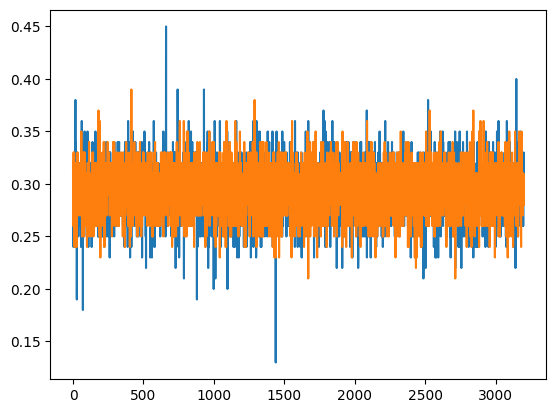

In [8]:
plt.plot(out_prop[:,-2:])

### Correcting the poisson's ratio

In [9]:
out_prop[:,-2] += 0.1
out_prop[:,-1] += 0.1

In [10]:
out_prop[:,-2] = np.divide(out_prop[:,-2], (out_prop[:,-2]+1))
out_prop[:,-1] = np.divide(out_prop[:,-1], (out_prop[:,-1]+1))

In [11]:
out_prop[:,-1] = np.round(out_prop[:,-1], decimals=3)
out_prop[:,-2] = np.round(out_prop[:,-2], decimals=3)

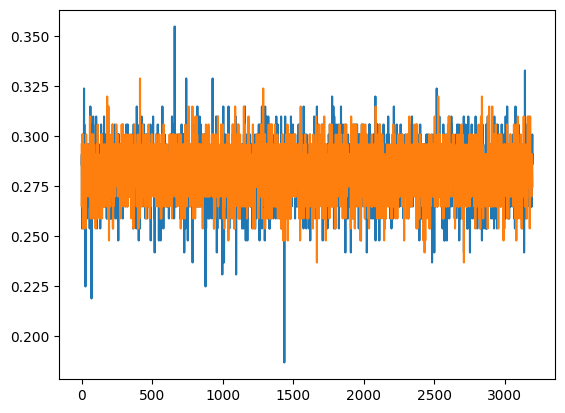

In [12]:
plt.plot(out_prop[:,-2:])

In [13]:
out_prop

array([[1.34214234e+05, 1.37459734e+05, 2.86000000e-01, 2.96000000e-01],
       [1.92807953e+05, 1.97270859e+05, 2.91000000e-01, 2.65000000e-01],
       [1.35382328e+05, 1.36449453e+05, 2.75000000e-01, 2.70000000e-01],
       ...,
       [1.77822062e+05, 1.78267188e+05, 3.01000000e-01, 2.86000000e-01],
       [2.36050984e+05, 2.38234812e+05, 2.86000000e-01, 2.81000000e-01],
       [2.58109141e+05, 2.61313984e+05, 2.91000000e-01, 2.75000000e-01]])

In [14]:
#------------------------------------------------------------------------------
#--------------------------------Data Preparation------------------------------
#------------------------------------------------------------------------------
from sklearn.preprocessing import MinMaxScaler

#Scaling the input modulus
input_mod_scaler = MinMaxScaler()
input_mod_scaler.fit(in_prop)
in_prop = input_mod_scaler.transform(in_prop)

#scaling the output modulus
output_mod_scaler = MinMaxScaler()
output_mod_scaler.fit(out_prop)
out_prop = output_mod_scaler.transform(out_prop)


In [15]:
output_mod_scaler.data_max_

array([3.08606562e+05, 3.07381469e+05, 3.55000000e-01, 3.29000000e-01])

In [16]:
output_mod_scaler.data_min_

array([8.88932188e+04, 8.80424609e+04, 1.87000000e-01, 2.37000000e-01])

In [17]:
#------------------------------------------------------------------------------
#--------------------------------Data Pipeline---------------------------------
#------------------------------------------------------------------------------
batch_size = 120

def parse_function(filename, in_prop, out_prop):
    """
    Loads the images and the material properties, performs preprocessing.

    Parameters
    ----------
    File name for the image

    """
    image = tf.image.decode_image(tf.io.read_file(filename))
    image = tf.image.crop_to_bounding_box(image, 0, 96, 752, 752)
    image = tf.image.convert_image_dtype(image[:,:,:3], tf.float32)
    image = tf.image.rgb_to_grayscale(image)
    # Prepare a mask
    mask = image<0.9
    mask = tf.cast(mask, 'float32')
    # Apply mask to image
    image = tf.where(image>0.5, 1.0, 0.5) * mask
    return image, in_prop, out_prop

dataset = tf.data.Dataset.from_tensor_slices((filename, in_prop, out_prop))
dataset = dataset.shuffle(buffer_size=4)
dataset = dataset.map(parse_function, num_parallel_calls=4)
train_dataset = dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(2)

## Implementing MLP

In [18]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.relu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

## Implement Patch creation layer

In [19]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

  def call(self, images):
      batch_size = tf.shape(images)[0]
      patches = tf.image.extract_patches(
          images=images,
          sizes=[1, self.patch_size, self.patch_size, 1],
          strides=[1, self.patch_size, self.patch_size, 1],
          rates=[1, 1, 1, 1],
          padding="VALID",
      )
      patch_dims = patches.shape[-1]
      patches = tf.reshape(patches, [batch_size, -1, patch_dims])
      return patches

In [20]:
for in_image, in_prop, out_prop in train_dataset:
  in_image, in_prop, out_prop = in_image, in_prop, out_prop
  break

In [21]:
print(in_image.shape, '\n', in_prop.shape, "\n", out_prop.shape)

(120, 752, 752, 1) 
 (120, 2) 
 (120, 4)


In [22]:
image_size = in_image.shape[1]
patch_size = 47

Image size: 752 X 752
Patch size: 47 X 47
Patches per image: 256
Elements per patch: 2209


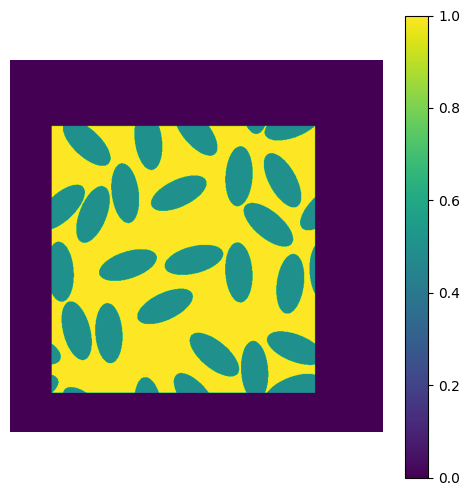

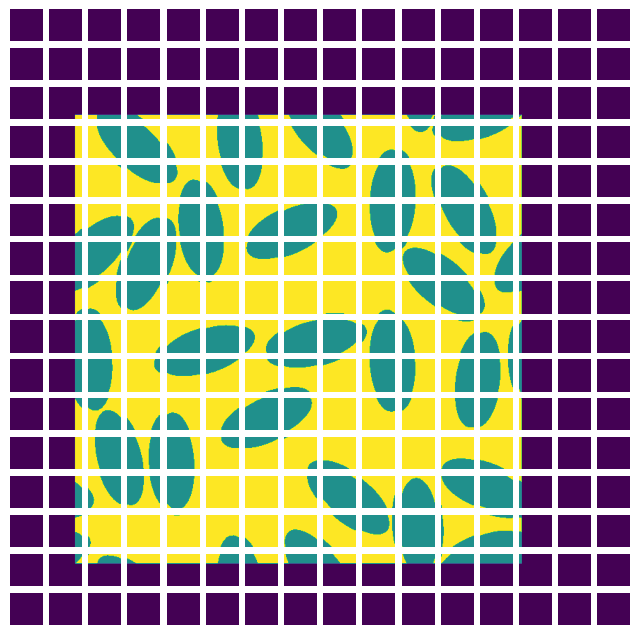

In [23]:
plt.figure(figsize=(6, 6))

image, a, b = parse_function("train_data/plots/micro150.png", None, None)
#image = in_image[np.random.choice(range(in_image.shape[0]))]
plt.imshow(image)
plt.colorbar()
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size))
    plt.imshow(patch_img, vmin=0, vmax=1)
    plt.axis("off")

## Patch encoding layer

In [24]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

## Hyperparameters

In [25]:
num_epochs = 200
image_size = 752  # We'll resize input images to this size
image_input_shape = (752,752,1)
property_input_shape = 2
patch_size = 47  # Size of the patches to be extracted from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [512, 512, 256]  # Size of the dense layers of the final classifier

In [26]:
def create_vit_model():
    image_inputs = layers.Input(shape=image_input_shape)
    # Create patches.
    patches = Patches(patch_size)(image_inputs)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.1)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.1)

    #Property encoding
    property_inputs = layers.Input(shape=property_input_shape)
    property_encoding = layers.Dense(64)(property_inputs)

    # Concatenate
    x = layers.Concatenate()([features, property_encoding])
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(512, activation='relu')(x)
    x =  layers.Dense(256, activation='relu')(x)
    #x =  layers.Dense(64, activation='relu')(x)
    output = layers.Dense(4)(x)

    # Create the Keras model.
    model = keras.Model(inputs=[property_inputs, image_inputs], outputs=output)
    return model

In [27]:
model = create_vit_model()

In [28]:
#-----------------------------------------------------------
#-------------------Prepare the Model-----------------------
#-----------------------------------------------------------
relu = tf.keras.layers.ReLU()
loss_fn = keras.losses.MeanSquaredError()

#@tf.function
def custom_loss(ypred, ytrue, in_prop):
    model_loss = loss_fn(ytrue, ypred)
    total_loss = model_loss

    return loss_fn(ytrue, ypred)


In [29]:
#-----------------------------------------------------------
#------------------------Training---------------------------
#-----------------------------------------------------------

@tf.function
def grad(model, x, in_prop, out_prop):
  with tf.GradientTape() as tape:
      model_output = model([in_prop, x])
      loss_value = loss_fn(model_output, out_prop)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

@tf.function
def train_step(x, in_prop, out_prop):
      # Optimize the model
      loss_value, grads = grad(model, x, in_prop, out_prop)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))
      return loss_value

train_loss_results = []
model_loss_tracking = []
start_time = time.time()

optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)
num_epochs = 100

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    for step, (x, in_prop, out_prop)  in enumerate(train_dataset):
        loss_value = train_step(x, in_prop, out_prop)
        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        model_loss_tracking.append(loss_value)
    # End epoch
    epoch_loss = epoch_loss_avg.result()
    train_loss_results.append(epoch_loss)
    if epoch % 1 == 0:
        print("Epoch {:03d}: Loss: {:.8f}".format(epoch, epoch_loss))

end_time = time.time()

print(f"Time take in training: {end_time - start_time} seconds")

Epoch 000: Loss: 0.04367536
Epoch 001: Loss: 0.01735604
Epoch 002: Loss: 0.01156678
Epoch 003: Loss: 0.00726805
Epoch 004: Loss: 0.00480125
Epoch 005: Loss: 0.00427387
Epoch 006: Loss: 0.00399596
Epoch 007: Loss: 0.00385924
Epoch 008: Loss: 0.00366395
Epoch 009: Loss: 0.00365724
Epoch 010: Loss: 0.00368102
Epoch 011: Loss: 0.00397730
Epoch 012: Loss: 0.00455848
Epoch 013: Loss: 0.00368107
Epoch 014: Loss: 0.00305939
Epoch 015: Loss: 0.00309912
Epoch 016: Loss: 0.00315450
Epoch 017: Loss: 0.00321528
Epoch 018: Loss: 0.00288112
Epoch 019: Loss: 0.00275746
Epoch 020: Loss: 0.00266196
Epoch 021: Loss: 0.00250412
Epoch 022: Loss: 0.00244309
Epoch 023: Loss: 0.00233252
Epoch 024: Loss: 0.00222422
Epoch 025: Loss: 0.00208100
Epoch 026: Loss: 0.00203950
Epoch 027: Loss: 0.00193302
Epoch 028: Loss: 0.00194505
Epoch 029: Loss: 0.00193306
Epoch 030: Loss: 0.00264357
Epoch 031: Loss: 0.00327706
Epoch 032: Loss: 0.00463634
Epoch 033: Loss: 0.00257966
Epoch 034: Loss: 0.00272075
Epoch 035: Loss: 0.0

In [30]:
np.savetxt("train_loss_results.csv", train_loss_results, delimiter=",")
np.savetxt("model_loss_tracking.csv", model_loss_tracking, delimiter=",")

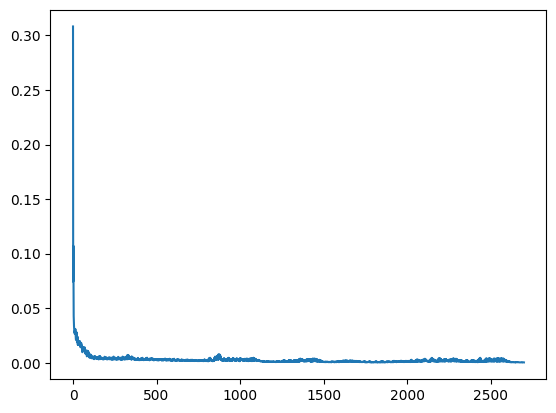

In [31]:
plt.plot(model_loss_tracking)

In [ ]:
#Save the trained model NOTE: Change file name before running
model.save(path + 'ViT_24_sep_Final.model')

## Load pre-trained model

In [ ]:
model = keras.saving.load_model(path + 'ViT_24_sep_Final.model')

## Plotting error on training set to make sure that model is not overfitting

In [ ]:
predictions = []
true = []
images = []
for x, in_prop, out_prop in train_dataset:
    pred = model([in_prop, x])
    true.append(out_prop)
    images.append(x)
    predictions.append(pred.numpy())

predictions = np.vstack(predictions)
true = np.vstack(true)

predictions = output_mod_scaler.inverse_transform(predictions)
true = output_mod_scaler.inverse_transform(true)

error = np.divide(np.abs((predictions-true)), true) * 100

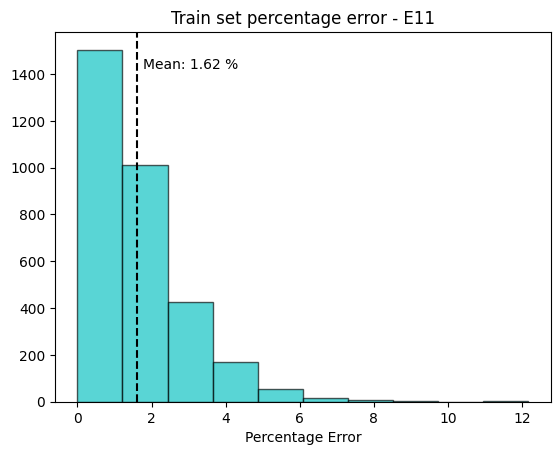

In [ ]:
x = error[:,0]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Train set percentage error - E11')
plt.xlabel('Percentage Error')

plt.savefig("vit_train_error_1.pdf")

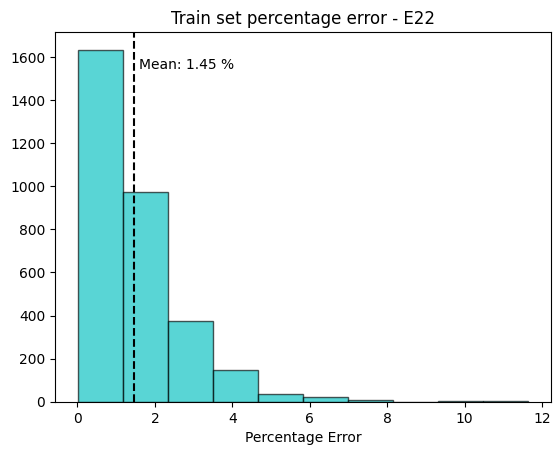

In [ ]:
x = error[:,1]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Train set percentage error - E22')
plt.xlabel('Percentage Error')

plt.savefig("vit_train_error_2.pdf")

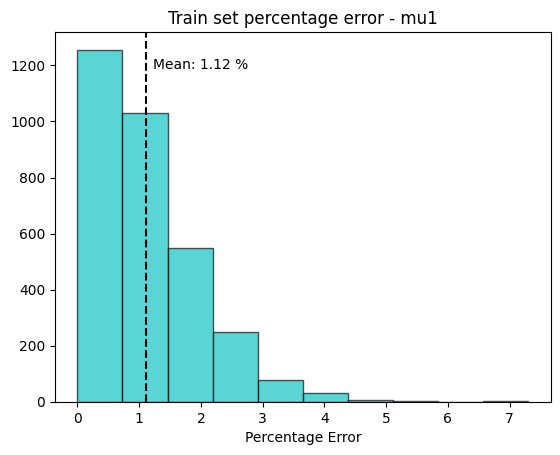

In [ ]:
x = error[:,2]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Train set percentage error - mu1')
plt.xlabel('Percentage Error')
plt.savefig("vit_train_error_3.pdf")

## Testing

### Load test data

In [ ]:
!mkdir test_data_repo

mkdir: cannot create directory ‘test_data_repo’: File exists


In [ ]:
hf_hub_download(repo_id="dhruvindankhara/microstructure_RVE", filename="test_data.zip", repo_type="dataset", local_dir="test_data_repo/")
# Copies data from drive to the local working directory
!unzip -q "/content/test_data_repo/test_data.zip"

replace test_data/micro_detail.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [ ]:
test_data = np.genfromtxt("test_data/micro_detail.csv", delimiter=",")

test_image_number = test_data[:,0].astype('int32') #image number

#List of image files
test_filename = []
for num in test_image_number:
  test_filename.append("test_data/plots/micro" + str(num) + ".png")

test_vol_frac = test_data[:,1] # Volume fraction in images
test_in_prop = test_data[:,6:8] # Properties of phase materials
test_out_prop = test_data[:,-4:] # Properties of RVE

In [ ]:
test_out_prop[:,-2:] += 0.1

In [ ]:
test_out_prop[:,-2] = np.divide(test_out_prop[:,-2], test_out_prop[:,-2]+1)
test_out_prop[:,-1] = np.divide(test_out_prop[:,-1], test_out_prop[:,-1]+1)

In [ ]:
test_out_prop

array([[1.55194469e+05, 1.55290156e+05, 2.95774644e-01, 3.05555557e-01],
       [2.10325266e+05, 2.06787594e+05, 2.85714292e-01, 2.80575535e-01],
       [2.17330062e+05, 2.16215375e+05, 2.75362319e-01, 2.70072998e-01],
       ...,
       [2.51946219e+05, 2.53785188e+05, 2.70072998e-01, 2.90780143e-01],
       [2.19169156e+05, 2.19956188e+05, 2.95774644e-01, 2.85714292e-01],
       [2.49039734e+05, 2.36799078e+05, 2.59259259e-01, 2.59259259e-01]])

In [ ]:
test_in_prop = input_mod_scaler.transform(test_in_prop)

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_filename, test_in_prop, test_out_prop))
test_dataset = test_dataset.map(parse_function, num_parallel_calls=4)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(2)

In [ ]:
#Testing one batch
predictions = []
true = []
images = []
for x, in_prop, out_prop in test_dataset:
    pred = model([in_prop, x])
    true.append(out_prop)
    images.append(x)
    predictions.append(pred)
    break

predictions = output_mod_scaler.inverse_transform(predictions[0])
#true = output_mod_scaler.inverse_transform(true[0])

error = np.divide(np.abs((predictions-true[0])), true[0]) * 100

In [ ]:
np.mean(error, axis=0)

array([3.628406  , 3.26150767, 3.66939892, 2.71855585])

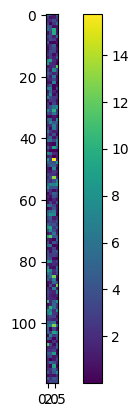

In [ ]:
plt.imshow(error)
plt.colorbar()

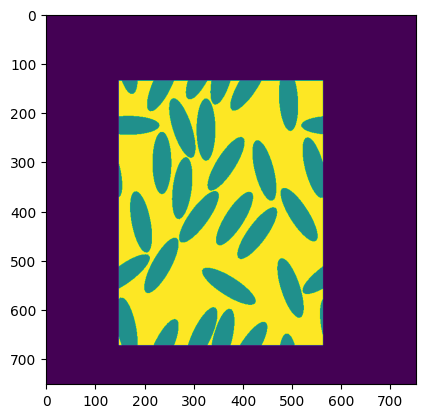

In [ ]:
plt.imshow(images[0][41])

## All test results

In [ ]:
predictions = []
true = []
images = []
for x, in_prop, out_prop in test_dataset:
    pred = model([in_prop, x])
    true.append(out_prop)
    images.append(x)
    predictions.append(pred.numpy())

predictions = np.vstack(predictions)
true = np.vstack(true)

predictions = output_mod_scaler.inverse_transform(predictions)
#true = output_mod_scaler.inverse_transform(true)

error = np.divide(np.abs((predictions-true)), true) * 100

In [ ]:
from sklearn import metrics

In [ ]:
i=3
metrics.r2_score(true[:,i], predictions[:,i])

0.18283883087220731

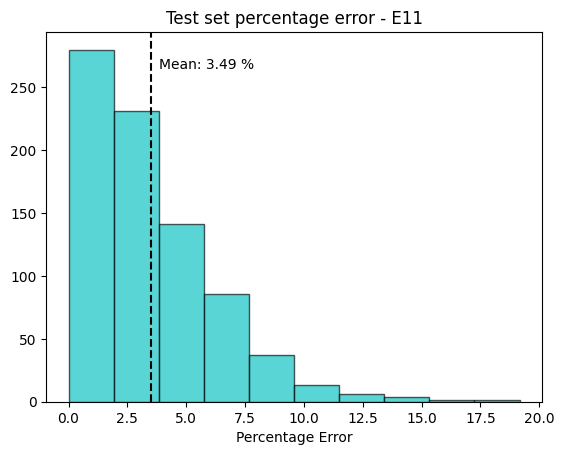

In [ ]:
x = error[:,0]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - E11')
plt.xlabel('Percentage Error')

plt.savefig("vit_test_error_1.pdf")

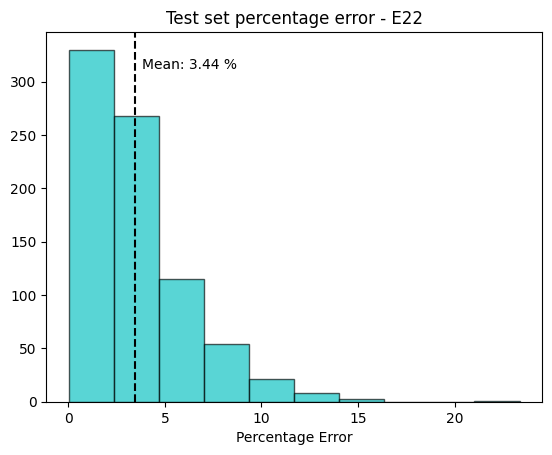

In [ ]:
x = error[:,1]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - E22')
plt.xlabel('Percentage Error')

plt.savefig("vit_test_error_2.pdf")

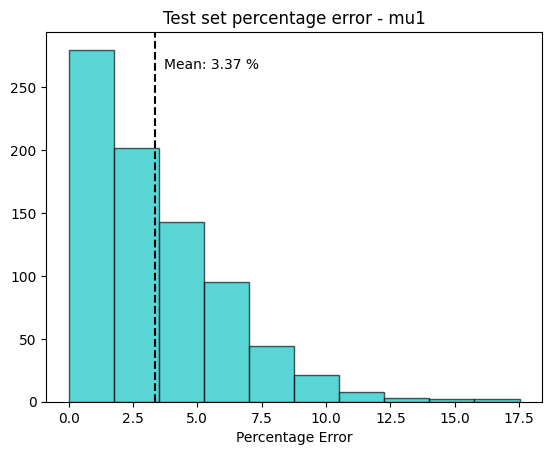

In [ ]:
x = error[:,2]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - mu1')
plt.xlabel('Percentage Error')

plt.savefig("vit_test_error_3.pdf")

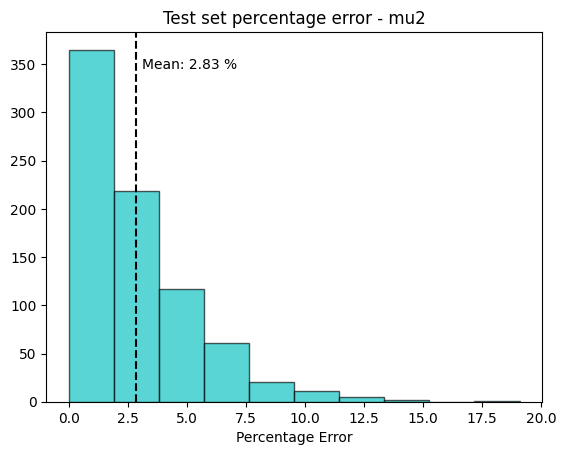

In [ ]:
x = error[:,3]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Test set percentage error - mu2')
plt.xlabel('Percentage Error')

plt.savefig("vit_test_error_4.pdf")

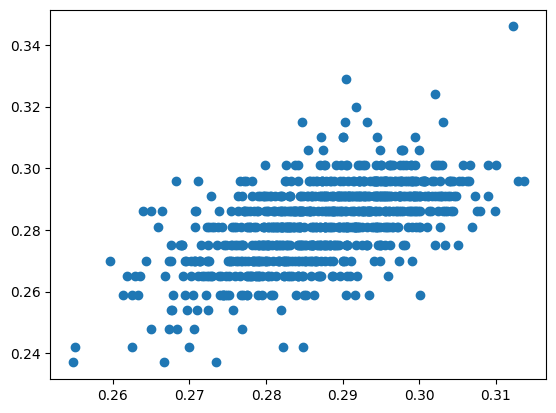

In [ ]:
plt.scatter(predictions[:,2], np.round(true[:,2], decimals=3))

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 752, 752, 1)]        0         []                            
                                                                                                  
 patches_1 (Patches)         (None, None, 2209)           0         ['input_1[0][0]']             
                                                                                                  
 patch_encoder (PatchEncode  (None, 256, 64)              157824    ['patches_1[0][0]']           
 r)                                                                                               
                                                                                                  
 layer_normalization (Layer  (None, 256, 64)              128       ['patch_encoder[0][0]']   

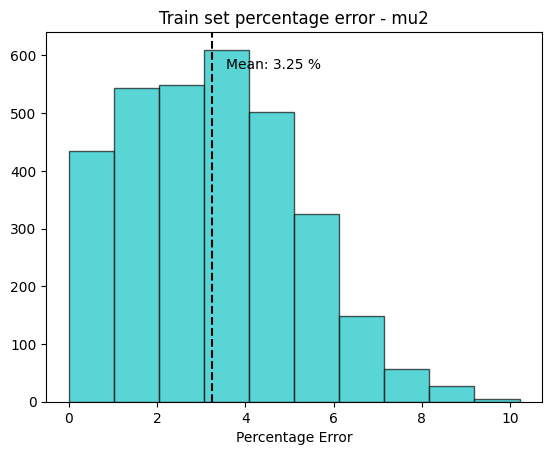

In [ ]:
x = error[:,3]

plt.hist(x, bins=10, color='c', edgecolor='k', alpha=0.65)
plt.axvline(x.mean(), linestyle='dashed', color='k')

min_ylim, max_ylim = plt.ylim()
plt.text(x.mean()*1.1, max_ylim*0.9, 'Mean: {:.2f} %'.format(x.mean()))

plt.title('Train set percentage error - mu2')
plt.xlabel('Percentage Error')

plt.savefig("vit_train_error_4.pdf")